In [1]:
root_path = '../../data/'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_recall_curve,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,auc,
    roc_curve
)

# Importar o mlflow
import mlflow
from mlflow.models import infer_signature

import json
import joblib

In [3]:
# Tornar a amostra reproduzível
SEED = 42

# Tamanho do dataset de testes 
TEST_SIZE = 0.2

# Coluna Target
TARGET_COLUMN = "default.payment.next.month"

#### Definir a diretoria onde as experiências são guardadas

In [4]:
from pathlib import Path

#uri = "../../mlruns"
#Path(uri).mkdir(parents=True, exist_ok=True)
uri = "http://localhost:5000"

mlflow.set_tracking_uri(uri)

#### Ler o ficheiro CSV e carregá-lo no dataframe

In [5]:
file_path = root_path + 'lending_data.csv'
df = pd.read_csv(file_path)

In [6]:
df.shape

(30000, 25)

In [7]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [8]:
df.ID.nunique()

30000

#### 1. Quantas features estão disponíveis? Quantos clientes?

    - Existem 24 features disponíveis no dataset.
    - Existem 30000 clientes.

Existem missing values?

In [9]:
df.isnull().values.any()

np.False_

Existem o mesmo número de clientes nas duas classes?

In [10]:
df.groupby(TARGET_COLUMN)[TARGET_COLUMN].count()

default.payment.next.month
0    23364
1     6636
Name: default.payment.next.month, dtype: int64

Não! O dataset é altamente desequilibrado.

#### 2. Quantos clientes têm no dataset que efectivamente foram maus pagadores? E quantos não foram?

    - 23,364 foram bons pagadores. 6,636 foram maus pagadores.

Existem features não númericas?

In [11]:
df.dtypes

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

Todas as features são númericas.

Vamos retirar o ID do cliente:

In [ ]:
df = df.drop('ID', axis = 1)

Vamos então dividir o dataset em treino e teste:

In [ ]:
train_set, test_set = train_test_split(df, test_size = TEST_SIZE, random_state = SEED)

# Utilizar apenas 20% dos dados treino
train_set = train_set.sample(frac=0.2, random_state = SEED)

In [22]:
X_train = train_set.drop([TARGET_COLUMN], axis = 'columns')
y_train = train_set[TARGET_COLUMN]

X_test = test_set.drop([TARGET_COLUMN], axis = 1)
y_test = test_set[TARGET_COLUMN]

Antes de iniciar, vamos calcular a baseline, ou seja, o custo que temos sem nenhum modelo.

$$totalCost = 1000∗FP+3000∗FN$$

In [106]:
y_preds_all_bad = np.ones(y_test.shape) 

In [107]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_bad).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 0
Number of True Positives: 1313
Number of False Negatives: 0
Number of False Positives: 4687


In [108]:
print('Total Cost:', fp*1000)

Total Cost: 4687000


In [109]:
accuracy_score(y_test, y_preds_all_bad)

0.21883333333333332

Se todos os clientes fossem considerados como maus pagadores, o banco teria um custo de 4,687,000 Euros.

In [110]:
y_preds_all_good = np.zeros(y_test.shape) 

tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_good).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 4687
Number of True Positives: 0
Number of False Negatives: 1313
Number of False Positives: 0


In [111]:
print('Total Cost:', fn*3000)

Total Cost: 3939000


In [112]:
accuracy_score(y_test, y_preds_all_good)

0.7811666666666667

Se todos os clientes fossem considerados bons pagadores, o banco teria um custo de 3,939,000 Euros.

In [113]:
def total_cost(y_test, y_preds, threshold = 0.5):
    
    tn, fp, fn, tp = confusion_matrix(y_test == 1, y_preds > threshold).ravel()
    
    cost_fn = fn*3000
    cost_fp = fp*1000
    
    return cost_fn + cost_fp
    

In [114]:
def min_cost_threshold(y_test, y_preds):
    
    min_cost = np.inf
    costs = {}
    for threshold in np.arange(0, 1.1, 0.1):       
        cost = total_cost(y_test, y_preds, threshold=threshold)
        costs[round(threshold, 1)] = cost 
    
        # Atualiza o melhor threshold se encontrar um custo menor
        if cost < min_cost:
            min_cost = cost
            best_threshold = threshold

    plt.plot(list(costs.keys()), list(costs.values()))
    plt.ylabel('Cost')
    plt.xlabel('Threshold')
    plt.show()
    return best_threshold 

#### Fazer set da experiência "Rumos Bank - Comparação de modelos"

In [115]:
# Criar experiência no MLflow
mlflow.set_experiment("Rumos Bank - Comparação de modelos")

<Experiment: artifact_location='mlflow-artifacts:/124521601411192047', creation_time=1743519954171, experiment_id='124521601411192047', last_update_time=1743519954171, lifecycle_stage='active', name='Rumos Bank - Comparação de modelos', tags={}>

#### Criar um run principal com configurações globais do dataset

In [116]:
# Guardar configurações globais:
mlflow.start_run(run_name="Configuraçõs Globais")

# Dataset 
full_dataset = mlflow.data.from_pandas(df, source=file_path, targets=TARGET_COLUMN, name="Full Dataset")
mlflow.log_input(full_dataset, context="full")

# Registar os parâmetros do split
mlflow.log_param("test_size", TEST_SIZE)

# Guardar a seed utilizado como parametro
mlflow.log_param("seed", SEED)

# Registar os tamanhos dos conjuntos
mlflow.log_param("train_samples", len(X_train))
mlflow.log_param("test_samples", len(X_test))

mlflow.log_param("cv", 5)
   
# Definir o formato esperado das entradas e saídas do modelo.
signature = infer_signature(X_train, y_train)

c:\Users\MMarcelo\AppData\Local\miniconda3\envs\OML\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../../data/lending_data.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\MMarcelo\AppData\Local\miniconda3\envs\OML\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\MMarcelo\AppData\Local\miniconda3\envs\OML\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforce

### Random Forests

#### Criar uma run - Random Forests

In [157]:
mlflow.start_run(run_name="Random Forests", nested=True)

<ActiveRun: >

#### Guardar modelo, artefactos, métricas e parametros da run

In [ ]:
%%time

rf = RandomForestClassifier(random_state = SEED,  class_weight = 'balanced').fit(X_train, y_train)

parameters = {'n_estimators':[10, 100, 200]}

clf_rf = GridSearchCV(rf, parameters, cv = 5).fit(X_train, y_train)

CPU times: total: 7min 51s
Wall time: 9min 29s


In [159]:
mlflow.set_tag("model_name", "Random Forests")

params = rf.get_params()

modified_params = {}
for k, v in params.items():
    modified_params[k] = v

# Registar hiperparâmetros
mlflow.log_params(modified_params)

In [160]:
# Melhor modelo encontrado
best_model = clf_rf.best_estimator_

# Registar o modelo
mlflow.sklearn.log_model(
    best_model, 
    artifact_path="random_forests", 
    registered_model_name="random_forests", 
    signature=signature
)

Registered model 'random_forests' already exists. Creating a new version of this model...
2025/04/01 21:04:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random_forests, version 2
Created version '2' of model 'random_forests'.


In [161]:
y_preds = clf_rf.predict_proba(X_test)[:,1]

# Seleciona apenas 600 previsões para registar no mlflow (evitar ero ao carregar o modelo)
y_preds_sample = y_preds[:600]

# Converter previsões para JSON
predictions_json = json.dumps({"predictions": y_preds_sample.tolist()})

# Guardar como artefato
with open("predictions.json", "w", encoding="utf-8") as f:
    f.write(predictions_json)

# Registrar no MLflow
mlflow.log_artifact("predictions.json")

In [162]:
# Registar métricas do melhor modelo
mlflow.log_metric("best_score", clf_rf.best_score_)

# Calcular métricas
accuracy = clf_rf.score(X_test, y_test) 
# Calcular recall - Metrica mais adequada para modelos desbalanceado em que o risco de falsos negativos (não identificar um cliente de risco) é mais grave
recall = recall_score(y_test, clf_rf.predict(X_test))

# Registrar no MLflow
mlflow.log_metric("accuracy", accuracy)
mlflow.log_metric("recall", recall)

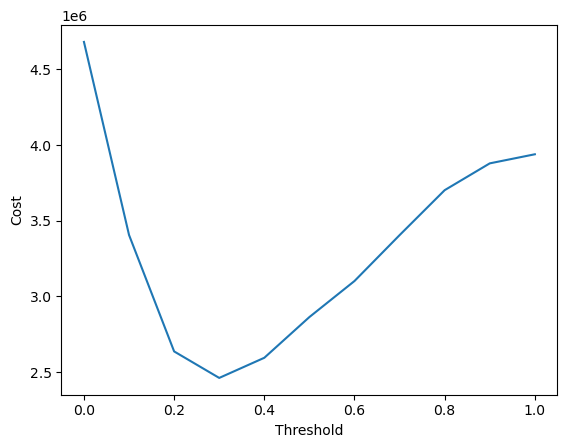

In [163]:
best_threshold = min_cost_threshold(y_test, y_preds)

In [164]:
cost = total_cost(y_test, y_preds, threshold = best_threshold)

mlflow.log_metric("total_cost", cost)
mlflow.log_param("best_threshold", best_threshold)

np.float64(0.30000000000000004)

#### Terminar a run

In [165]:
mlflow.end_run()

🏃 View run Random Forests at: http://localhost:5000/#/experiments/124521601411192047/runs/09f844f99c934a1ba84d21731579a981
🧪 View experiment at: http://localhost:5000/#/experiments/124521601411192047


Melhor resultado até agora!

In [174]:
mlflow.end_run()

🏃 View run ANN at: http://localhost:5000/#/experiments/124521601411192047/runs/65cff892a7d847e489112f50b6443758
🧪 View experiment at: http://localhost:5000/#/experiments/124521601411192047


#### Terminar a run principal

In [175]:
mlflow.end_run()

🏃 View run Configuraçõs Globais at: http://localhost:5000/#/experiments/124521601411192047/runs/71a92bfa556342ad9e87ce91b4f7b053
🧪 View experiment at: http://localhost:5000/#/experiments/124521601411192047


Resultado quase igual às random forests!

#### 3. Qual o modelo que levou a melhores resultados? Qual a métrica usada para comparar os diferentes modelos?

- A métrica usada foi o custo total uma vez que o objetivo do modelo era diminuir os custos do banco. O Modelo que levou a melhores resultados foram as neural networks e as random forests - 2,467,000 de custo.  
- Visto que com as neural networks não consigo saber qual a importancia das features, vou eleger o modelo de random forests como a solução final. Para além disso o treino das neural networks demorou quase o dobro do tempo.

#### 4. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para ser mau pagador?

In [176]:
rf = RandomForestClassifier(**clf_rf.best_params_).fit(X_train, y_train)

In [177]:
important_features = pd.DataFrame(data = rf.feature_importances_, index = X_train.columns, columns = ['value'])
important_features.sort_values(by = 'value', ascending = False)

,value
PAY_0,0.097225
AGE,0.066437
BILL_AMT1,0.060104
LIMIT_BAL,0.059370
BILL_AMT2,0.054417
PAY_AMT1,0.051680
BILL_AMT3,0.051244
BILL_AMT5,0.050275
BILL_AMT6,0.050207
BILL_AMT4,0.049946


As variaveis que mais contribuem para o modelo decidir se um cliente vai ser um bom ou mau pagador são:
    - PAY_0 - Repayment status in September, 2005 
    - e AGE - idade do cliente
    

#### 5. Qual seria o custo que o banco tem sem nenhum modelo?

    - O custo que o banco teria sem modelo, ou seja, assumindo que todos os clientes seriam bons pagadores, é de: 3,939,000 Euros.

#### 6. Qual o custo que o banco passa a tar com o vosso modelo?

- O custo que o banco teria com o modelo seria de: 2,476,000 Euros - Pouparia quase 1 Milhão e meio de Euros!